# CellRank2 analysis of TE002 (CytoTRACE)

In [1]:
# a.1) setup path to data-containing folder and savings and parameters
h5ad_path = "/Users/AlexanderWang/Desktop/ics-rebuttal/TE002-h5ad/"
figures_dir = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/"
figures_dir_CytoTRACEKernel = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/"
figures_dir_TE002 = "/Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/TE002/"

n_macro_CytoTRACE = 8 # number of macrostates 

In [2]:
# a.2) packages
import sys
import cellrank as cr
from VIPERKernel import VIPERKernel
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import os
from matplotlib import rc_context
import matplotlib.pyplot as plt
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

import warnings
warnings.simplefilter("ignore", category=UserWarning)

cytotrace_markers = ['Smarca5','Rbbp7','Tcerg1','Hnrnpd','Hmg20b','Nelfe','Ube2i','Etv5','Ubn1','Mbd3','Dek','Maz',
                     'Itgb3bp','Ilf2','Pa2g4'] # Id3','Hnf4g','Atoh1','Spdef','Neurod1' markers upregulated in cytotrace (Fig 1e) 

In [5]:
# a.3) load counts data (exported from Seurat@RNA assay)
counts_h5ad = h5ad_path + "TE002-cells-original-data.h5ad"
adata = sc.read_h5ad(counts_h5ad) # load in object


# a.4) load metadata for TE002
metadata_csv = h5ad_path + "rad-metadata-ingest.csv"
metadata = pd.read_csv(metadata_csv)

In [6]:
# a.5) process metadata in adata
adata.obs.index.names = ['cell_id']
cells_to_analyze = metadata['cell_id'] # cells to analyze
adata = adata[adata.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata

adata.obs = pd.merge(adata.obs, metadata, on='cell_id', how='left').set_index('cell_id') # merge metadata and include into counts object
adata.obs['iter_cluster_id_with_paneth'] = adata.obs['iter_cluster_id_with_paneth'].astype('category') # VIPER clusters as categorical variable

# a.6) set UMAP coordinates to those obtained at protein activty
umap_coordinates = np.array(adata.obs.loc[:, ['UMAP_1','UMAP_2']]) 
adata.obsm['X_umap'] = umap_coordinates

# a.7) Include metadata of terminal states for CellRank analysis
adata.obs['terminal_states'] = adata.obs['iter_cluster_id_with_paneth']
adata.obs['terminal_states'].iloc[adata.obs['terminal_states'].isin(["stem-1","stem-2"])] = np.nan

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [11]:
### b) Preprocess the data 
print("Preprocessing counts matrix for CellRank 2 analysis")
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)

Preprocessing counts matrix for CellRank 2 analysis


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
##########################################################################################################
##########################################################################################################
### CellRank2 analysis with CytoTRACE Kernel
##########################################################################################################
##########################################################################################################

### c) CytoTRACE kernel
# c.1) Setup kernel
print("Working with CytoTRACE kernel")
from cellrank.kernels import CytoTRACEKernel
import scvelo as scv
# CytoTRACE by default uses imputed data - a simple way to compute
# k-NN imputed data is to use scVelo's moments function.
# However, note that this function expects `spliced` counts because
# it's designed for RNA velocity, so we're using a simple hack here:
if 'spliced' not in adata.layers or 'unspliced' not in adata.layers:
    adata.layers['spliced'] = adata.X
    adata.layers['unspliced'] = adata.X
scv.pp.moments(adata) # hack for CytoTRACEkernel

ctk = CytoTRACEKernel(adata) # initialize the CellRank2 kernel

# c.2) compute transition matrix
ctk = ctk.compute_cytotrace().compute_transition_matrix(threshold_scheme="soft",nu=0.5) # compute transition matrix

Working with CytoTRACE kernel
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Computing CytoTRACE score with `31053` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)
Computing transition matrix based on pseudotime


  0%|          | 0/619 [00:00<?, ?cell/s]

    Finish (0:00:00)


In [14]:
# c.2) Set up figure directories
if os.path.exists(figures_dir):
    print("'figures_dir' directory already exists")
else:
    os.mkdir(figures_dir)

if os.path.exists(figures_dir_CytoTRACEKernel):
    print("'figures_dir_VIPERKernel' directory already exists")
else:
    os.mkdir(figures_dir_CytoTRACEKernel)

if os.path.exists(figures_dir_TE002):
    print("'figures_dir_TE001' directory already exists")
else:
    os.mkdir(figures_dir_TE002)

'figures_dir' directory already exists


/Users/AlexanderWang/opt/miniconda3/envs/cellrank_env_py3_10_osx_arm64/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


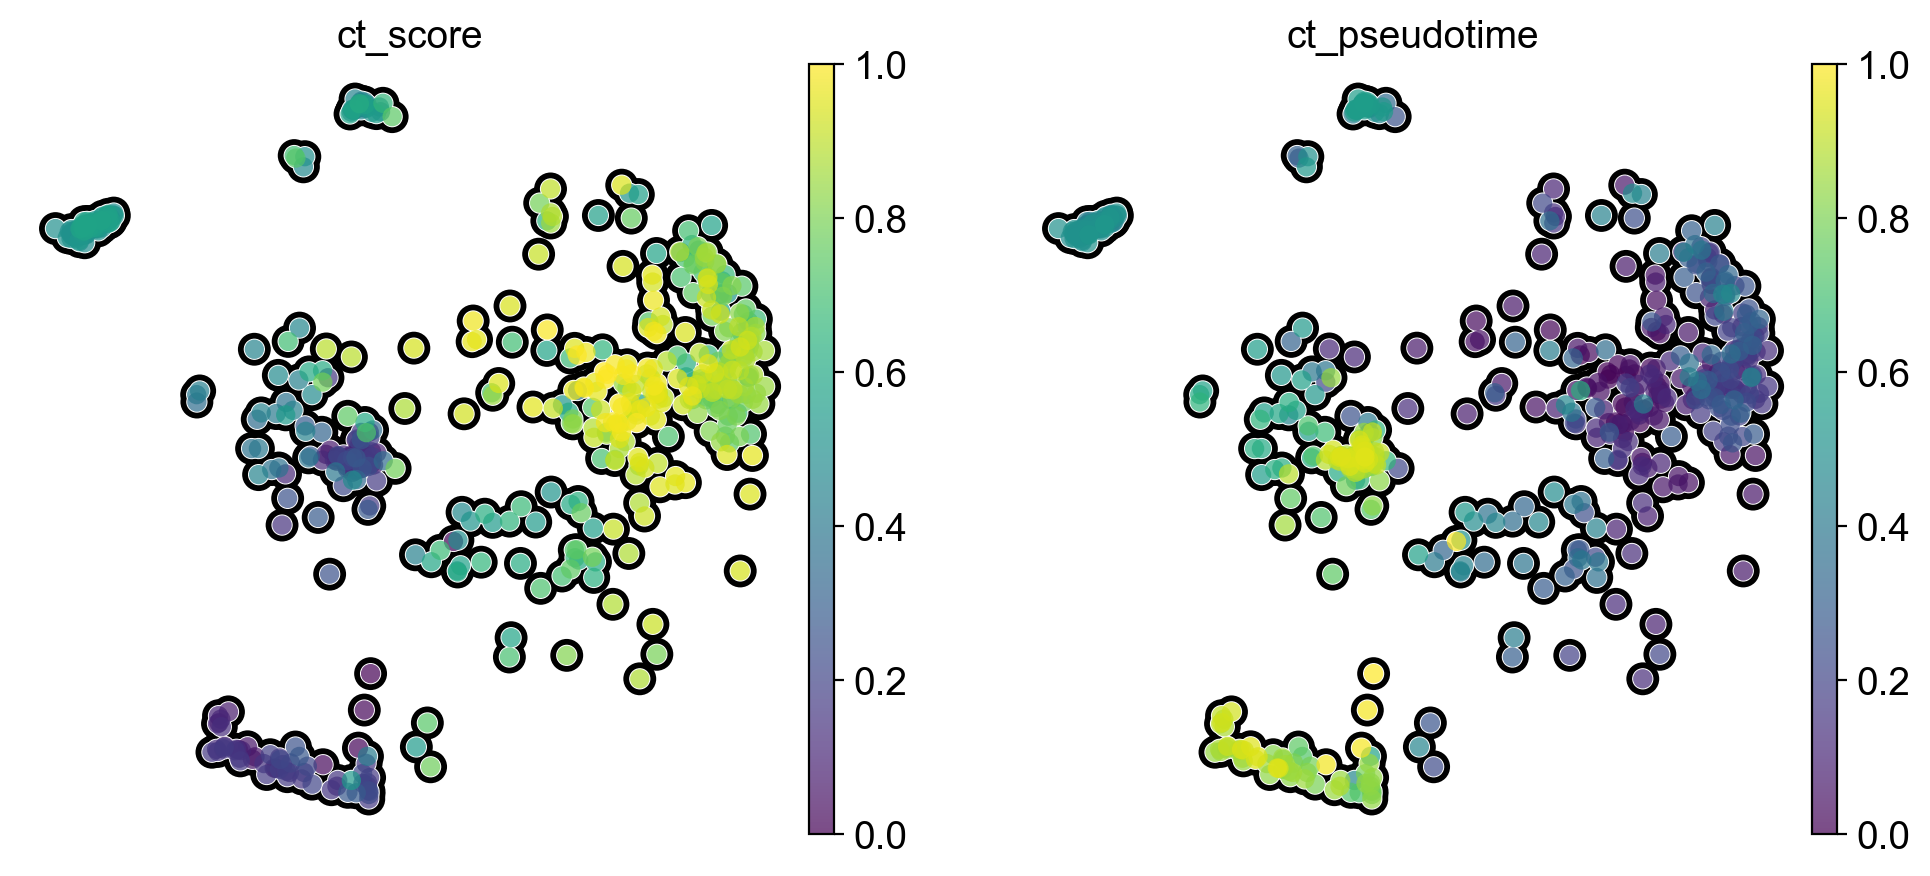

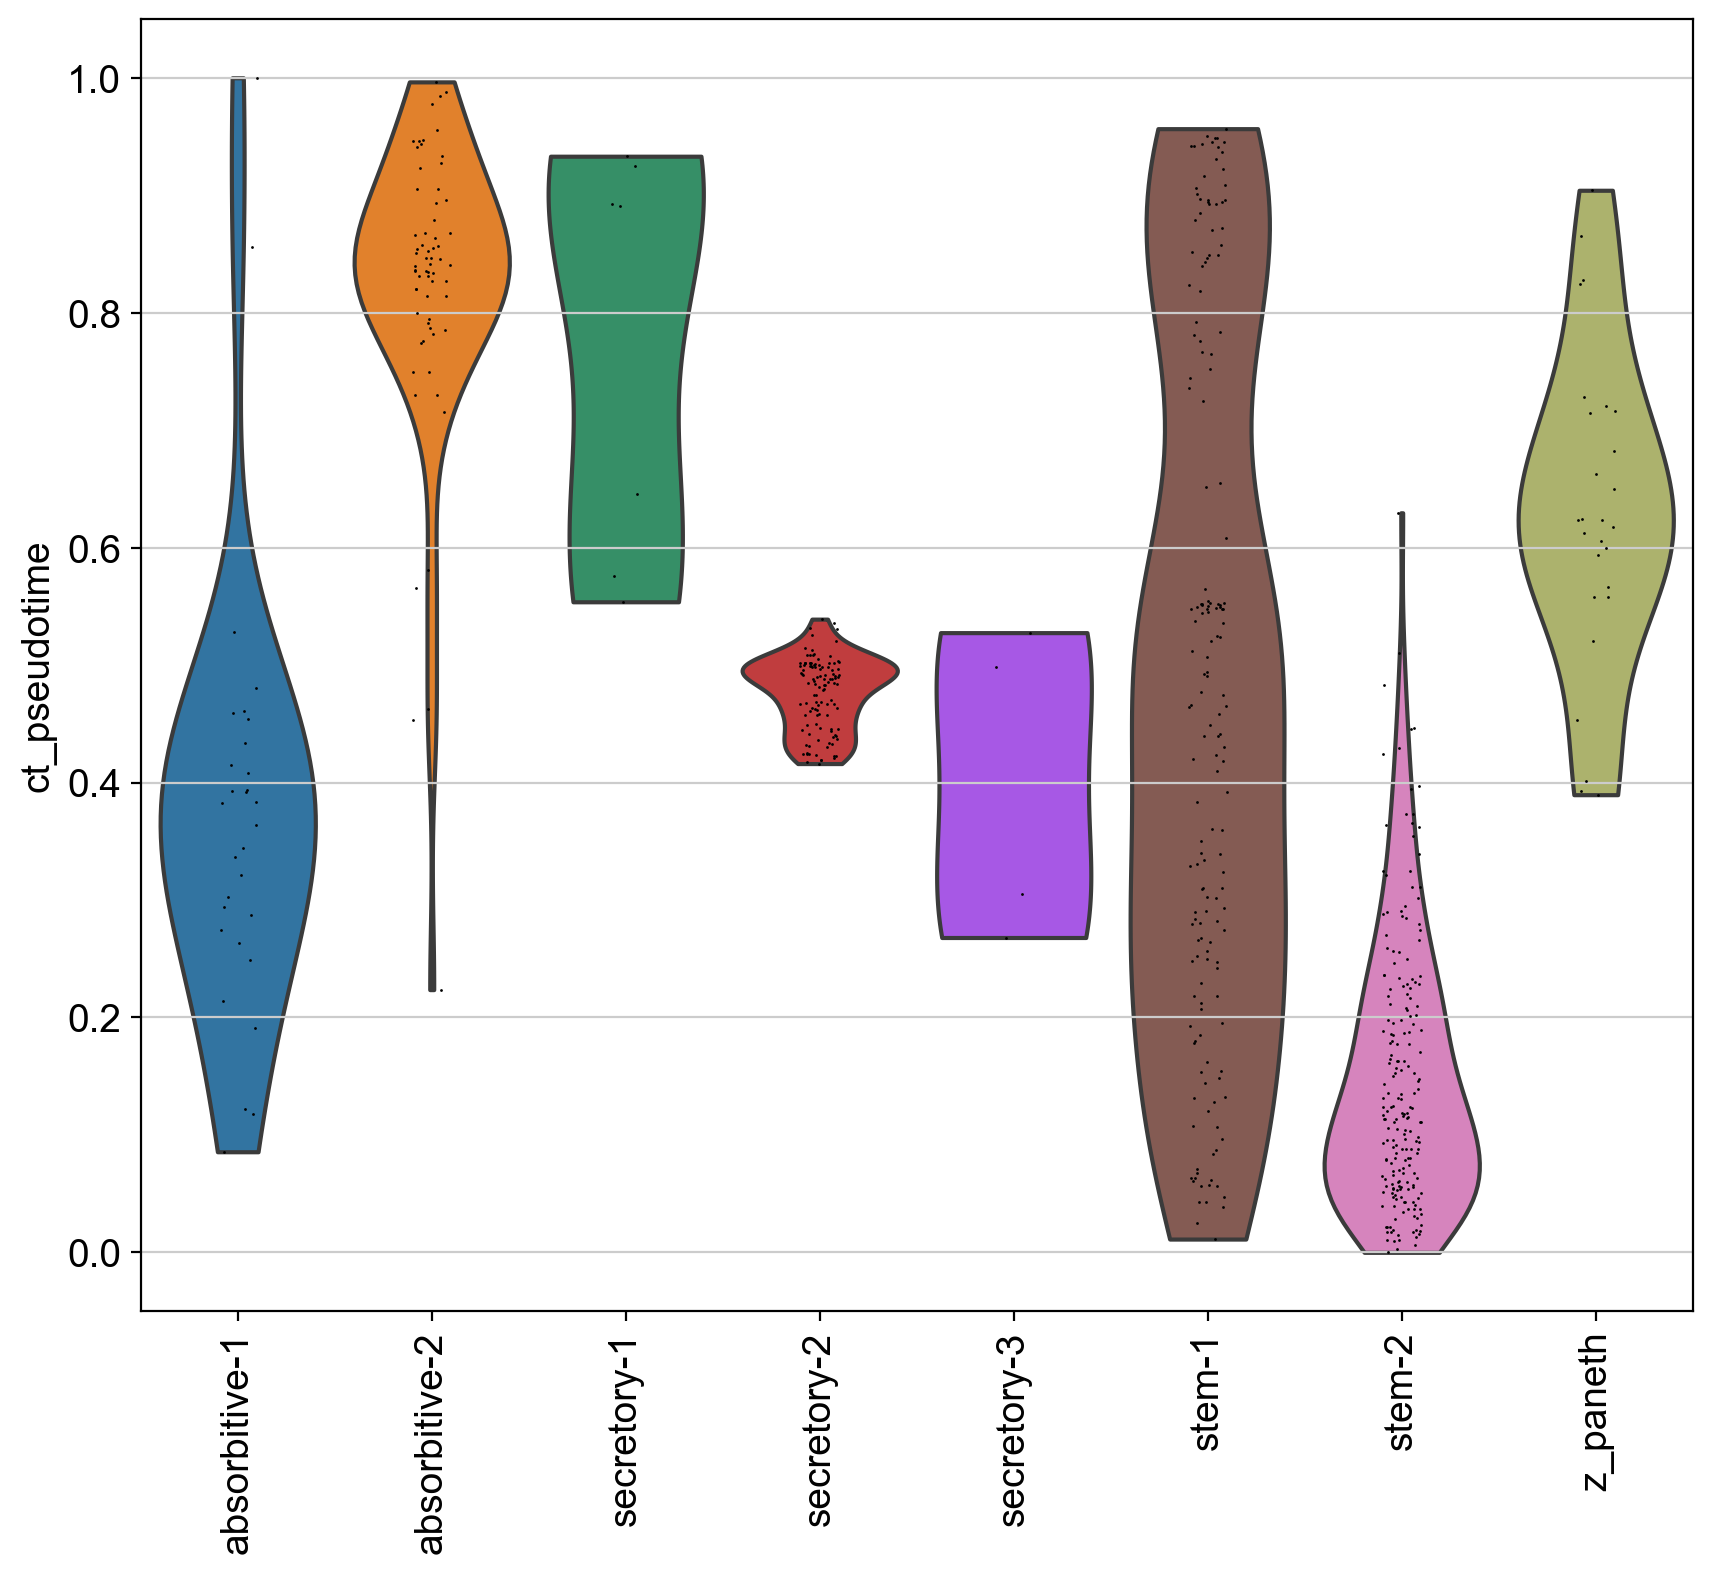

In [16]:
ctk_pseudotime_figure = figures_dir_CytoTRACEKernel + "CytoTRACE_pseudotime.pdf"
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color=['ct_score', 'ct_pseudotime'], show=False, add_outline=True)
    plt.savefig(ctk_pseudotime_figure)

ctk_pseudotime_vln = figures_dir_CytoTRACEKernel + "CytoTRACE_pseudotime_vln.pdf"
with rc_context({'figure.figsize': (8.5, 8.5)}):
    sc.pl.violin(adata, keys=["ct_pseudotime"], groupby="iter_cluster_id_with_paneth", rotation=90, show=False)
    plt.savefig(ctk_pseudotime_vln)

Simulate random walk on the Markov Chain implied by the transition matrix. Starting cells are selected at random. In the first figure, starting cells are selected randomly from all clusters. In figures 2 and 3 they are randomly sampled from the 'stem-1' and 'stem-2' clusters. 100 trajectories are simulated in each Random Walk. Black dots = cells of departure; yellow dots = cells of arrival.

Simulating `100` random walks of maximum length `155`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:00)
Plotting random walks
Simulating `100` random walks of maximum length `155`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:00)
Plotting random walks
Simulating `100` random walks of maximum length `155`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:00)
Plotting random walks


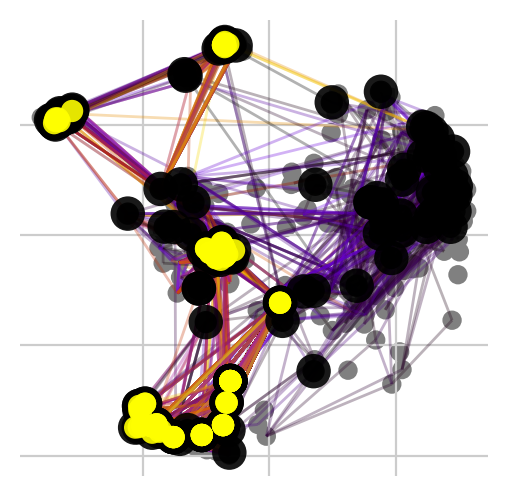

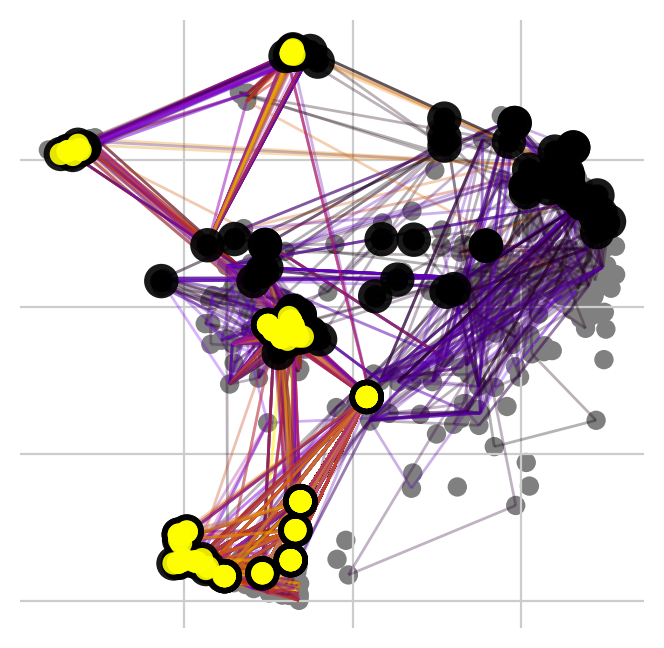

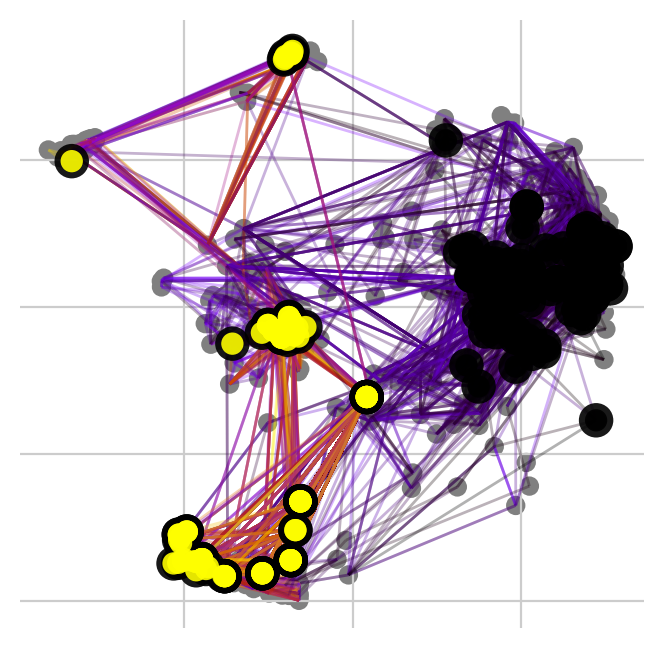

In [19]:
# c.3) Simulate a random walk on the Markov chain implied by the transition matrix 
ctk_rw_figure = figures_dir_TE002 + "CytoTRACEKernel_random_walk.pdf"
ctk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs=None,
    legend_loc="right",
    dpi=100,
    save=ctk_rw_figure,
    figsize=(3,3)
)

# c.4) Simulate a random walk on the Markov chain implied by the transition matrix 
# sampling cells randomly among all clusters
ctk_rw_figure = figures_dir_TE002 + "CytoTRACEKernel_random_walk_stem-1.pdf"
ctk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={'iter_cluster_id_with_paneth':'stem-1'},
    legend_loc="right",
    dpi=100,
    save=ctk_rw_figure
)

# c.5) visualize the transition matrix
# sampling cells randomly from stem-1 population
ctk_rw_figure = figures_dir_TE002 + "CytoTRACEKernel_random_walk_stem-2.pdf"
ctk.plot_random_walks(
    seed=0,
    n_sims=100,
    start_ixs={'iter_cluster_id_with_paneth': "stem-2"},
    legend_loc="right",
    dpi=100,
    save=ctk_rw_figure
)

Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:00)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/TE002/CytoTRACEKernel_differentiation_pa_clusters.svg


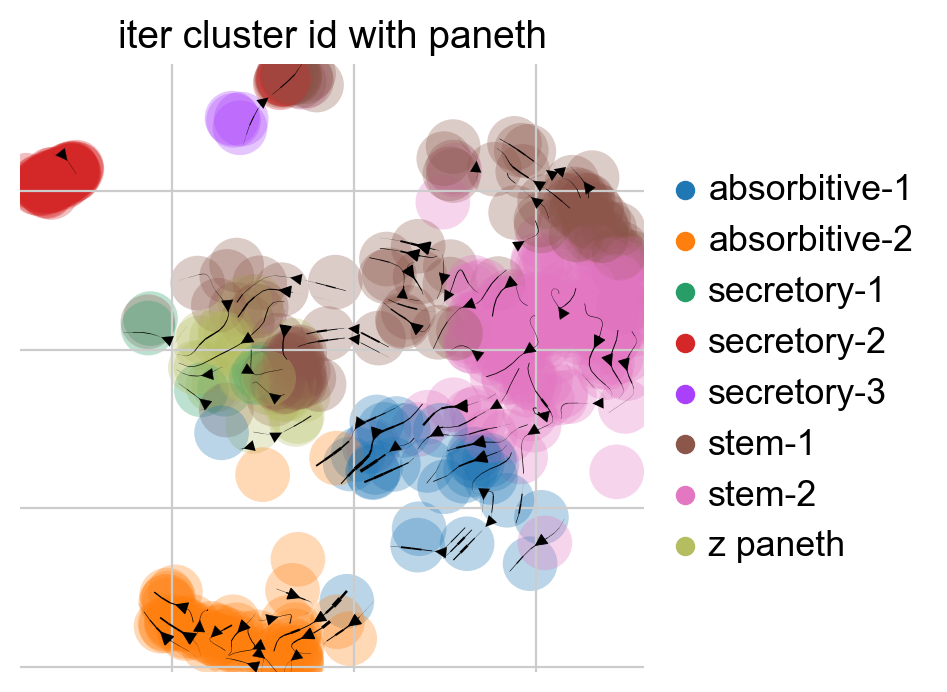

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_CytoTRACEKernel/TE002/CytoTRACEKernel_differentiation_cytotrace.svg


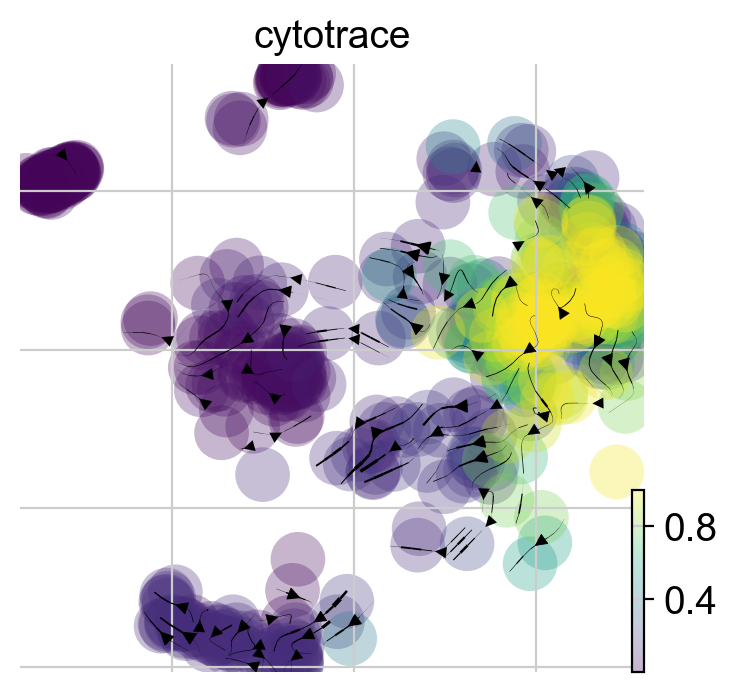

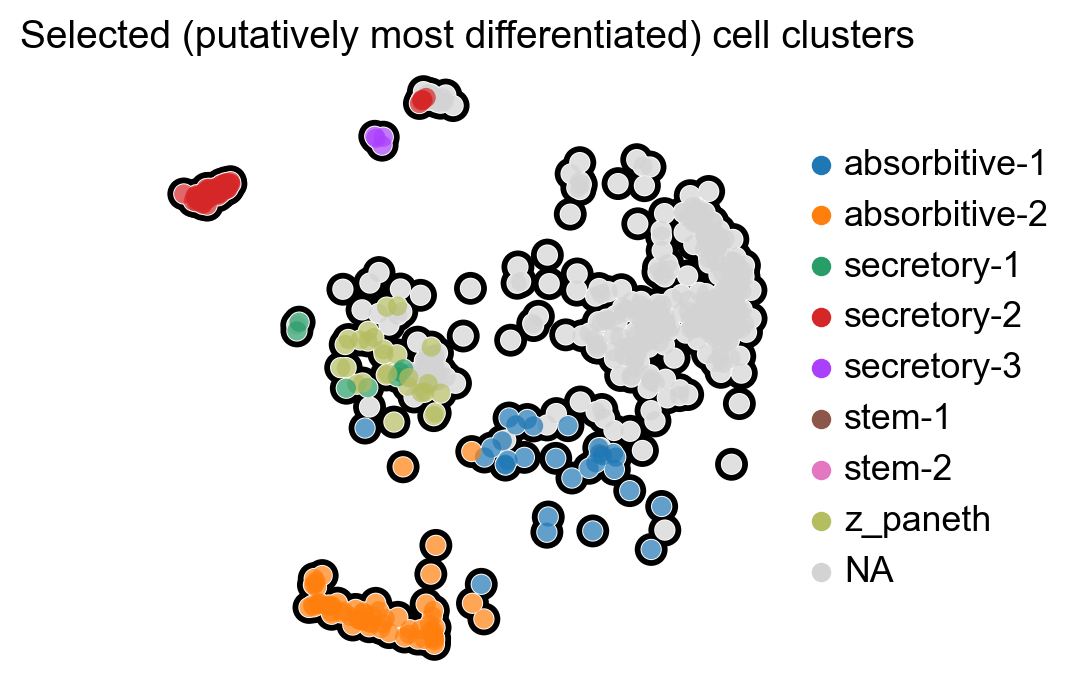

In [17]:
# c.6) visualize the transition matrix
differentiation_figure = figures_dir_TE002 + "CytoTRACEKernel_differentiation_pa_clusters.svg"
ctk.plot_projection(basis="umap",
                    color = "iter_cluster_id_with_paneth", 
                    legend_loc="right", save=differentiation_figure, show=True)

differentiation_figure = figures_dir_TE002 + "CytoTRACEKernel_differentiation_cytotrace.svg"
ctk.plot_projection(basis="umap",
                    color="cytotrace", 
                    legend_loc="right", save=differentiation_figure, show=True)

# c.7) Check terminal states from annotations
annotated_terminal_states_figure = figures_dir_TE002 + "annotated_terminal_states.pdf"
sc.pl.embedding(adata, basis="umap", color="terminal_states", add_outline=True, title="Selected (putatively most differentiated) cell clusters") 
#####################